# Previsão do número de mortes por Covid-19 no Brasil

Neste problema, vamos usar o modelo de espaço de estados considerando o número de casos diários e o número total de pessoas vacinadas como variáveis preditoras.

Este notebook foi baseado no notebook do site:  https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb para os dados de consumo de energia elétrica na Austrália.

Os dados utilizados neste notebook foram baixados no site:

https://ourworldindata.org/coronavirus/country/brazil


In [1]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(14, 8), dpi=200)
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

<Figure size 2800x1600 with 0 Axes>

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [4]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(14, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [5]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Leitura dos dados

In [6]:
covid = pd.read_csv(f'data/owid-covid-data.csv', index_col='date', parse_dates=True)
covid = covid[covid["location"] == "Brazil"] # É possível testar outros países

# Escolha das variáveis a serem usadas como exógenas no modelo
covid = covid[['new_cases','new_deaths','new_vaccinations','total_vaccinations','population']]
# As variáveis de vacinação têm uma escala muito maior do que a de casos e de mortes. Por isso, essa variável é normalizada
# pelo tamanho da população
covid[['new_vaccinations','total_vaccinations']] = covid[['new_vaccinations','total_vaccinations']]/covid['population'].iloc[0]

idx = pd.date_range(start=covid.index.min(), end=covid.index.max(), freq='D')
covid = covid.reindex(idx)

# preenchimento dos dados faltantes com os dados do passo anterior (útil para séries temporais)
covid.fillna(method='ffill',inplace=True)
covid['new_deaths'].fillna(method='ffill',inplace=True)

# Formatação da data (útil para os gráficos abaixo)
date_fmt = mdates.DateFormatter('%b %Y')
date_loc = mdates.WeekdayLocator(byweekday=mdates.WE)

## Análise gráfica das séries

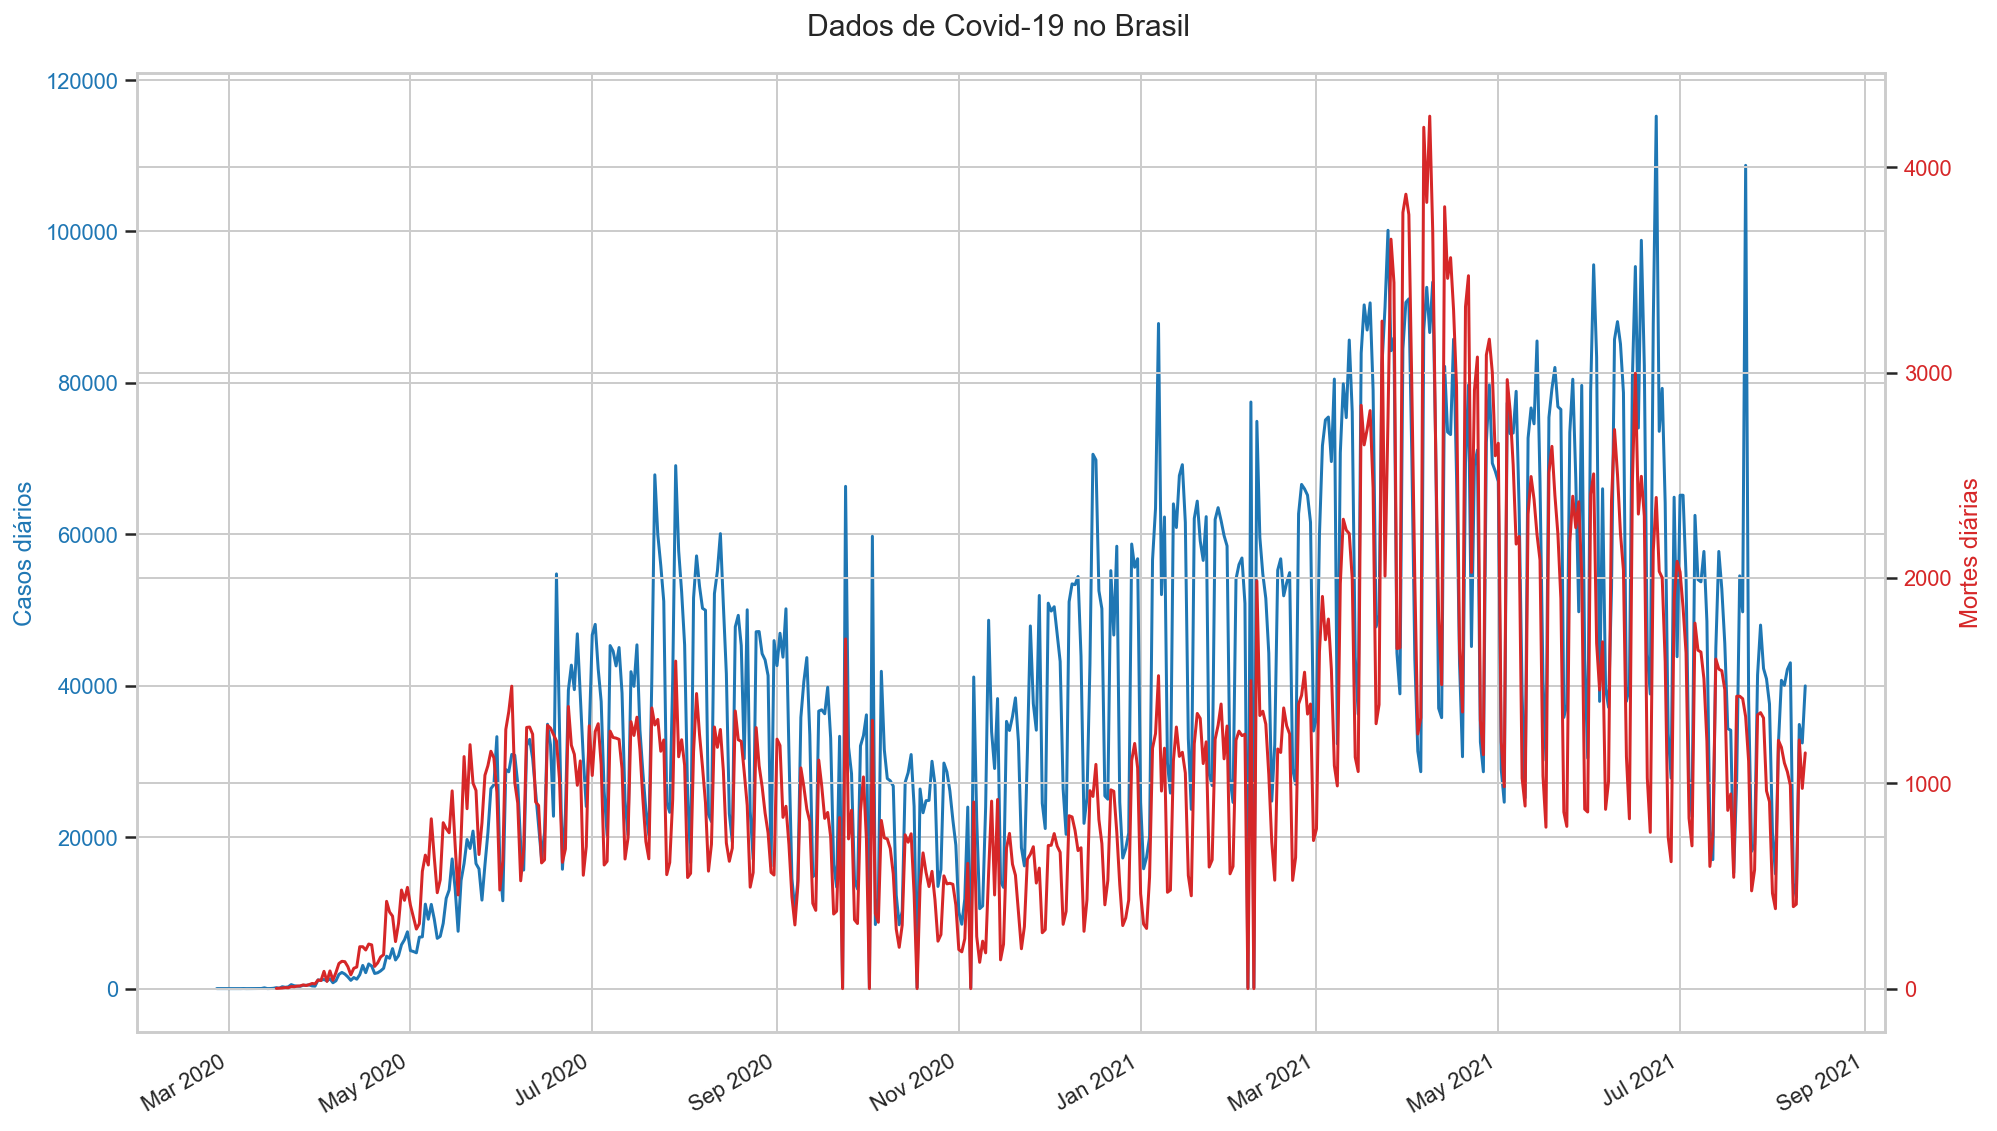

In [7]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Casos diários', color=color)
ax1.plot(covid['new_cases'].index,covid['new_cases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mortes diárias', color=color)  # we already handled the x-label with ax1
ax2.plot(covid['new_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Como a sazonalidade semanal é artificial, ou seja, ela não representa a realidade, o número de casos e de mortes diárias não deve depender diretamente dos dias da semana. Por este motivo, decidimos trabalhar com a mediana móvel. A mediana móvel usada neste notebook não é a de séries temporais, mas sim a de processamento de sinais, em que os valores futuros são também levados em conta. Isso foi feito porque tentar minimizar o problema da subnotificação e o de dados discrepantes. Para esta análise, estamos interessados apenas em prever a tendência do número de mortes.

**Remoção da sazonalidade semanal**

In [8]:
from scipy import signal

# Esta mediana é calculada de forma diferente do filtro mediana das séries temporais. O tamanho da janela foi escolhido 
# de forma a minimizar a discrepância da série em uma faixa de dias (discutir na apresentação)
covid['new_deaths_f'] = signal.medfilt(covid['new_deaths'], 7)
covid['new_cases_f'] = signal.medfilt(covid['new_cases'], 7)
covid['new_vaccinations_f'] = signal.medfilt(covid['new_vaccinations'], 7)
covid['total_vaccinations_f'] = signal.medfilt(covid['total_vaccinations'], 7)

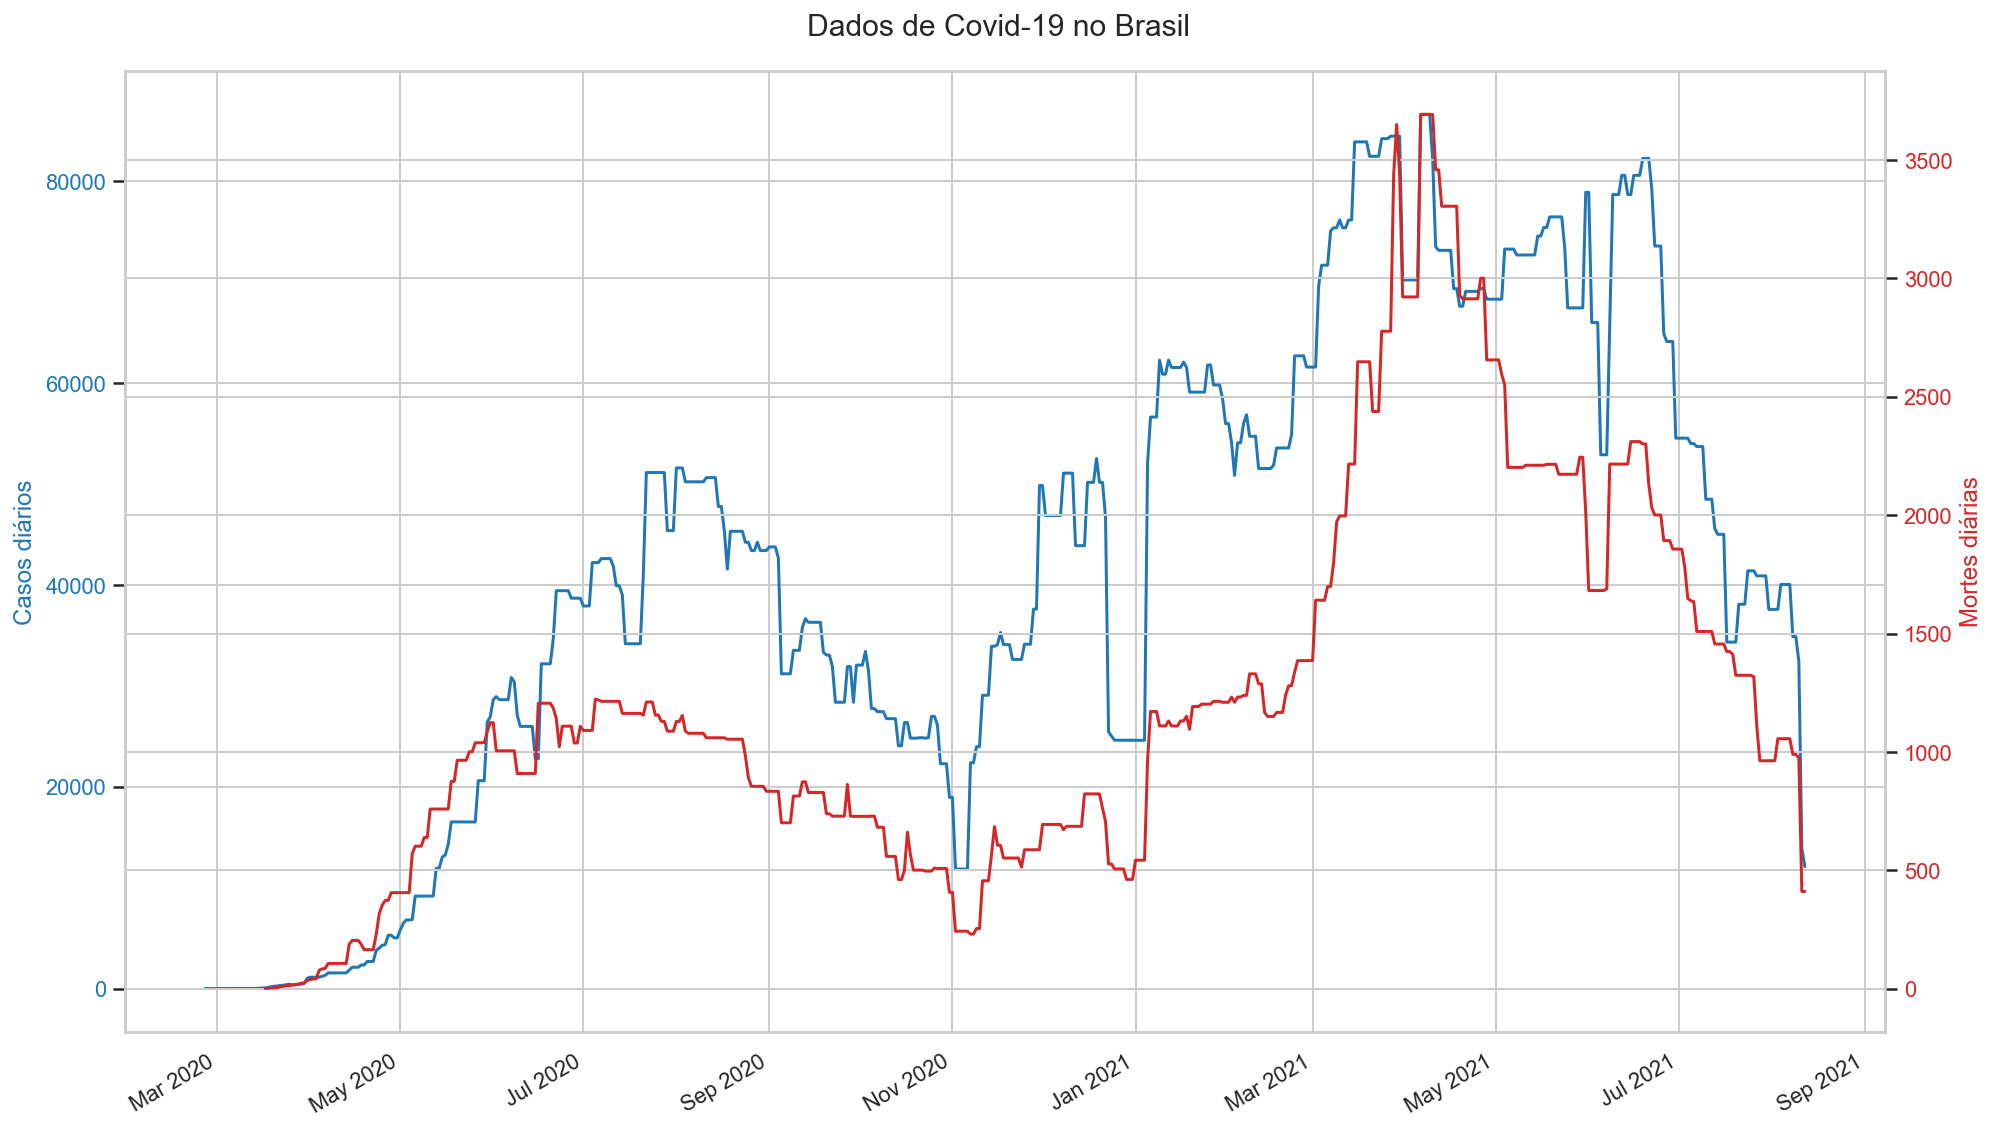

In [9]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Casos diários', color=color)
ax1.plot(covid['new_cases_f'].index,covid['new_cases_f'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mortes diárias', color=color)  # we already handled the x-label with ax1
ax2.plot(covid['new_deaths_f'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Remoção dos dados faltantes e discrepantes**

In [10]:
from scipy import signal

# Esta mediana é calculada de forma diferente do filtro mediana das séries temporais. O tamanho da janela foi escolhido 
# de forma a minimizar a discrepância da série em uma faixa de dias (discutir na apresentação)
covid['new_deaths_f'] = signal.medfilt(covid['new_deaths'], 35)
covid['new_cases_f'] = signal.medfilt(covid['new_cases'], 35)
covid['new_vaccinations_f'] = signal.medfilt(covid['new_vaccinations'], 7)
covid2 = covid

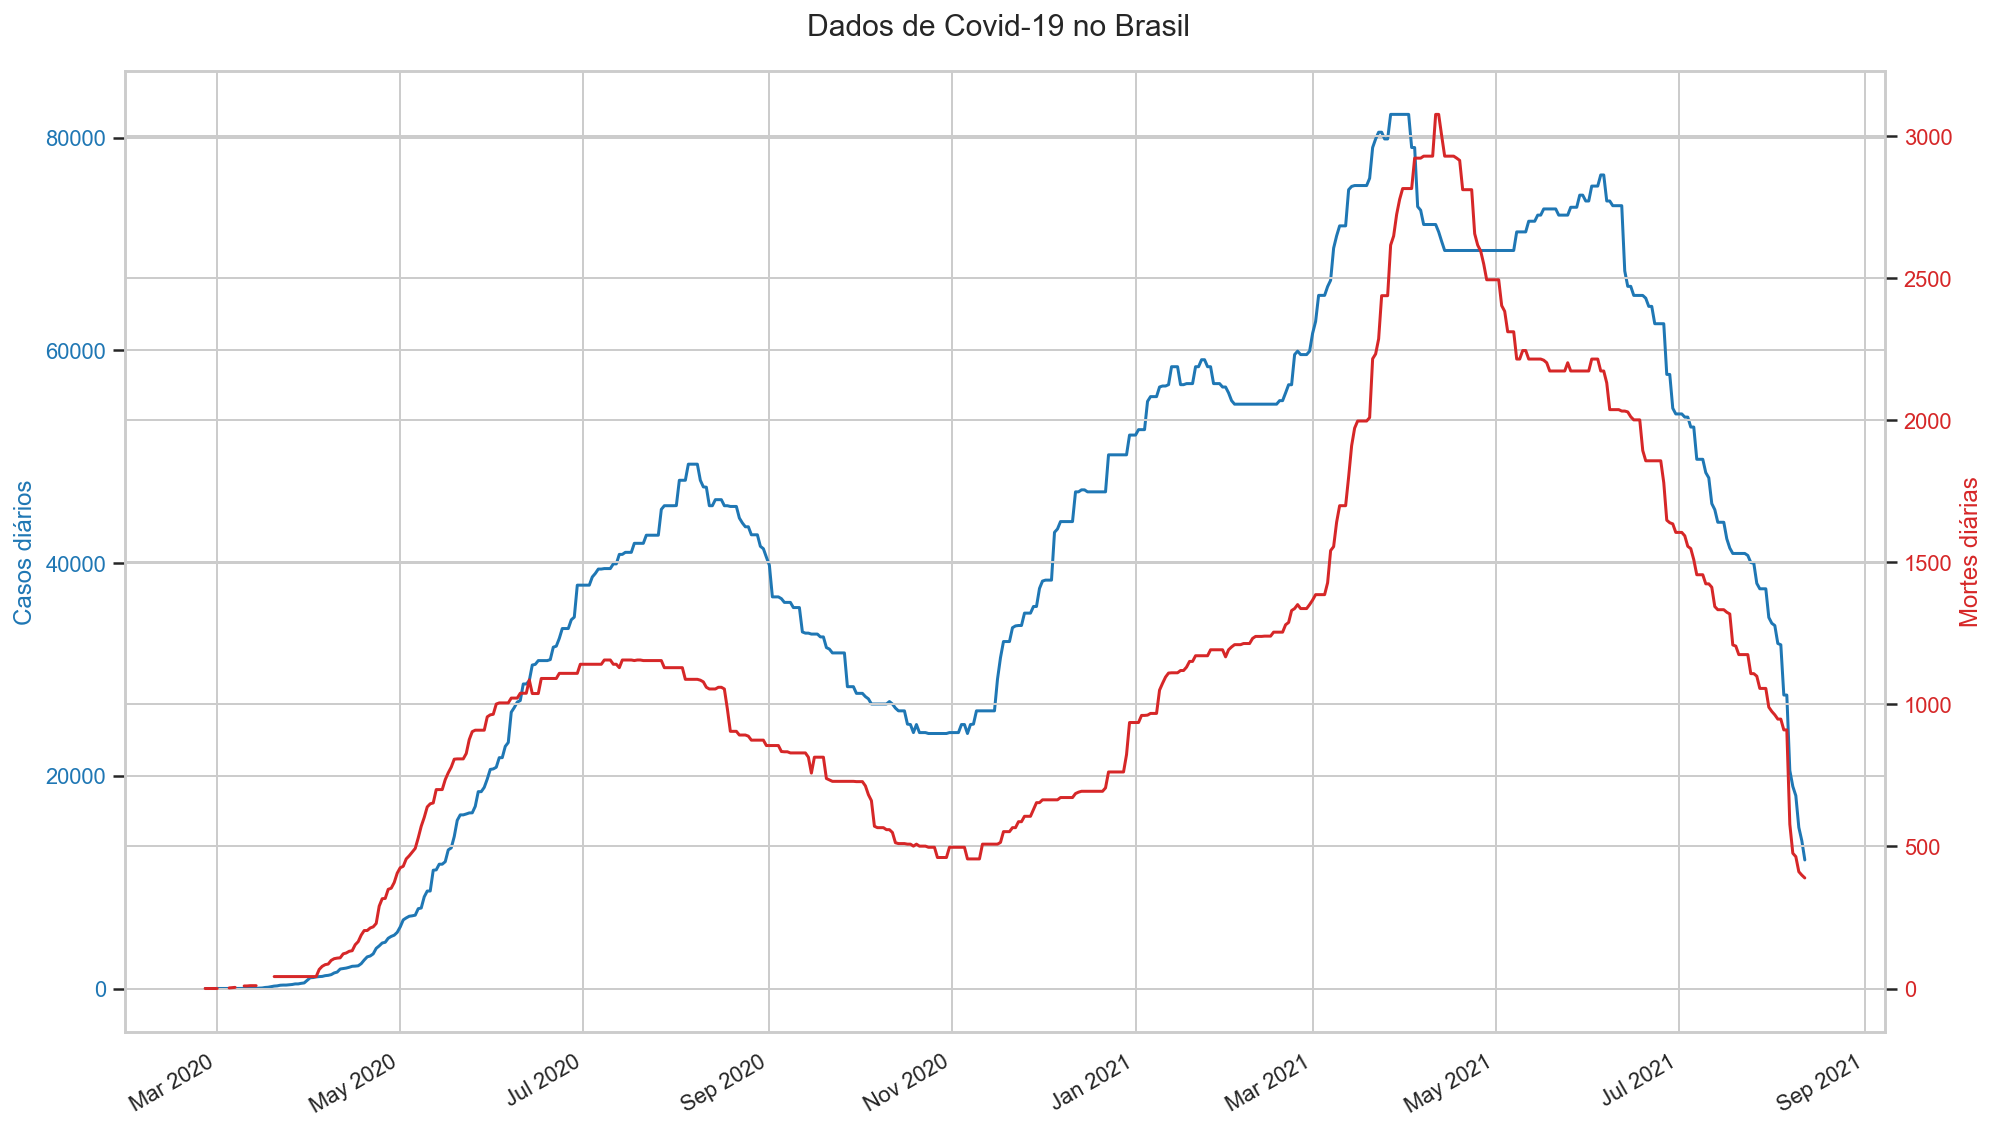

In [11]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Casos diários', color=color)
ax1.plot(covid['new_cases_f'].index,covid['new_cases_f'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mortes diárias', color=color)  # we already handled the x-label with ax1
ax2.plot(covid['new_deaths_f'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Pareamento das séries**

In [12]:
# Definição do intervalo de análise das séries

# Brazil
start_date = '2020-04-01'
covid = covid2.iloc[covid2.index>start_date,:]
covid = covid.iloc[covid.index<'2021-08-07',:]

# Italy
#start_date = '2020-03-01'
#covid = covid2.iloc[covid2.index>start_date,:]
#covid = covid.iloc[covid.index<'2021-07-17',:]

# deslocamento da série de número de casos para pareá-la com a do número de mortes diárias e o de vacinação
death_days = 18 # número dias médios em que o paciente falece após ser diagnosticado com Covid-19

covid = covid[['new_cases_f','new_deaths_f','new_vaccinations_f','total_vaccinations_f']]
covid['new_vaccinations_f'].fillna(0,inplace=True)
covid['total_vaccinations_f'].fillna(0,inplace=True)

new_deaths_f = covid['new_deaths_f'].iloc[death_days:].values
covid = covid.iloc[:-death_days,]
covid['new_deaths_f'] = new_deaths_f

# definição do conjunto de treinamento
num_forecast_steps = 30 # número de passos à frente para previsão do número de óbitos
covid_training = covid.iloc[:-num_forecast_steps,]

# Brazil
covid_dates = np.arange(start_date, covid.shape[0], dtype='datetime64[D]')

# Italy
#covid_dates = np.arange(start_date, covid.shape[0], dtype='datetime64[D]')

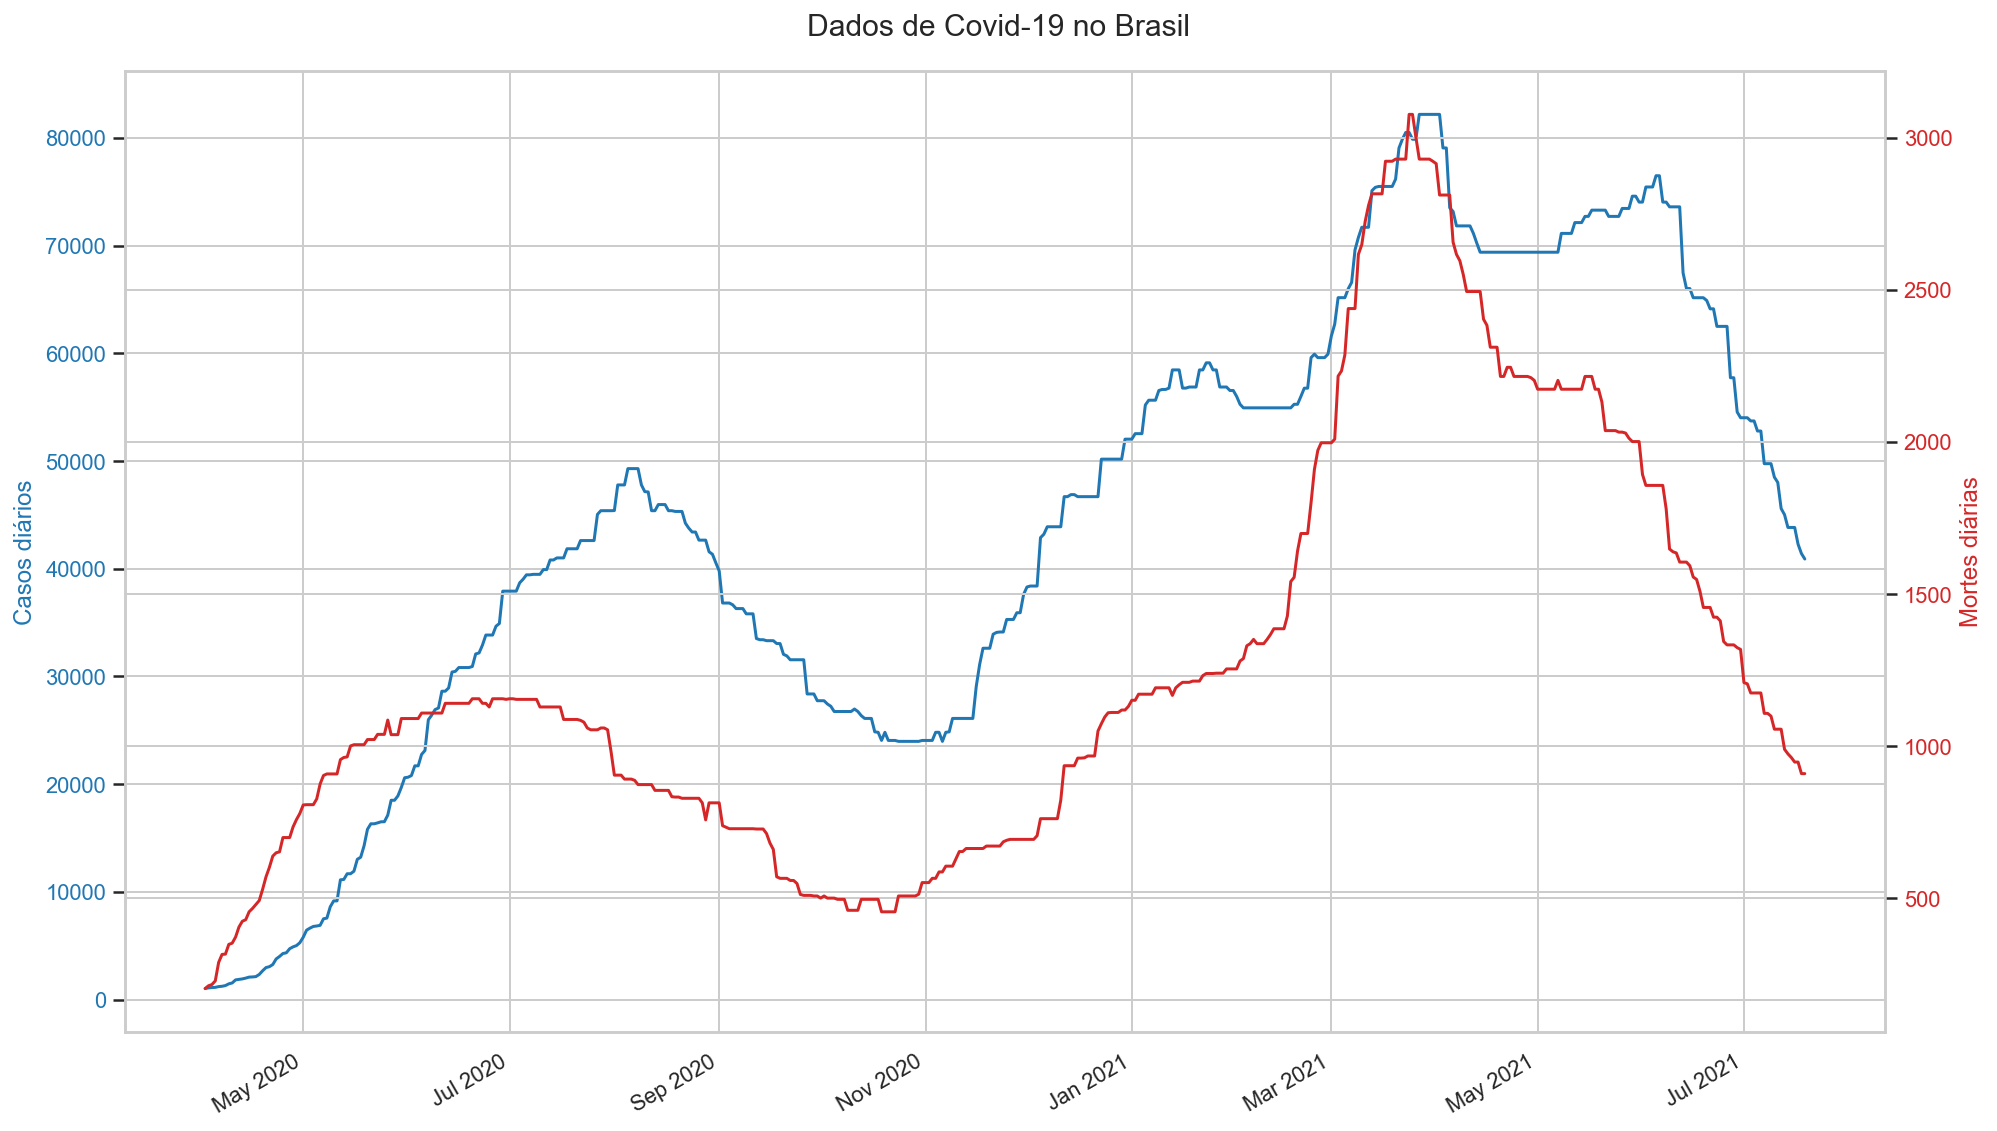

In [13]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Casos diários', color=color)
ax1.plot(covid['new_cases_f'].index,covid['new_cases_f'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Mortes diárias', color=color)  # we already handled the x-label with ax1
ax2.plot(covid['new_deaths_f'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Modelo e ajuste

Nosso modelo combina tendência local, regressão linear com o número de casos diários como variável preditora e um processo autoregressivo para os resíduos vinculados à variância.

In [14]:
def build_model(new_deaths,new_cases,vaccinations):
  # componente sazonal de 7 dias
  day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=1,
      observed_time_series=new_deaths,
      name='day_of_week_effect')

  # variável exógena número de casos diários
  new_cases_effect = sts.LinearRegression(
      design_matrix=tf.reshape(new_cases - np.mean(new_cases),
                               (-1, 1)), name='new_cases_effect')

  # variável exógena vacinação
  vaccination_effect = sts.LinearRegression(
      design_matrix=tf.reshape(vaccinations - np.mean(vaccinations),
                               (-1, 1)), name='vaccination_effect')

  # modelo autoregressivo de ordem 1
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=new_deaths,
      name='autoregressive')

  # componente de tendência linear local (define se a série observada continua crescendo ou descrescendo baseada no último
  # valor observado)
  local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=new_deaths, 
    name='local_linear_trend')

  # componente de nível local (define se a série observada continua mantendo o nível anterior)
  local_level = tfp.sts.LocalLevel(
    observed_time_series=new_deaths, 
    name='local_level')

  # composição do modelo final (podem testar várias combinações)
  model = sts.Sum([new_cases_effect,
                  vaccination_effect,
                  #local_level,
                  #local_linear_trend,
                  autoregressive],
                  observed_time_series=new_deaths)
  return model

Como no exemplo da aula (série de C02), vamos ajustar um modelo com inferência variacional e gerar amostras da distribuição a posteriori.

In [15]:
covid_model = build_model(covid_training['new_deaths_f'],covid['new_cases_f'],covid['total_vaccinations_f'])

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=covid_model)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


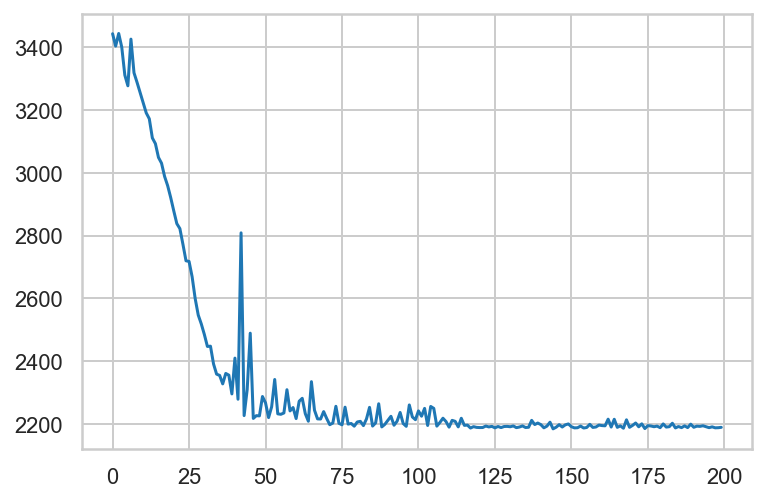

In [16]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(jit_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=covid_model.joint_log_prob(
        observed_time_series=covid_training['new_deaths_f']),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_covid_ = variational_posteriors.sample(100)

In [17]:
print("Inferred parameters:")
for param in covid_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_covid_[param.name], axis=0),
                              np.std(q_samples_covid_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 3.324174887373866 +- 0.7173133031077277
new_cases_effect/_weights: [0.00836333] +- [0.00201981]
vaccination_effect/_weights: [-2.38394116] +- [6.40477682]
autoregressive/_coefficients: [0.99564689] +- [0.00182509]
autoregressive/_level_scale: 31.401269041518894 +- 1.1661620633212926


## Previsão

Agora nós fazemos a previsão simplesmente chamando `tfp.sts.forecast` com o nosso modelo, a série temporal e os parâmetros ajustados.

In [18]:
covid_forecast_dist = tfp.sts.forecast(
    model=covid_model,
    observed_time_series=covid_training['new_deaths_f'],
    parameter_samples=q_samples_covid_,
    num_steps_forecast=num_forecast_steps)

In [19]:
num_samples=10

(
    covid_forecast_mean,
    covid_forecast_scale,
    covid_forecast_samples
) = (
    covid_forecast_dist.mean().numpy()[..., 0],
    covid_forecast_dist.stddev().numpy()[..., 0],
    covid_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

**Erro relativo para cada valor predito**

In [20]:
results = pd.DataFrame({'observed': covid['new_deaths_f'].iloc[-num_forecast_steps:], 'forecast': covid_forecast_mean})
predictions = round(100*np.abs(results['observed']-results['forecast'])/results['observed'],2)
predictions.tail(30)

2021-06-20     0.12
2021-06-21     0.57
2021-06-22     1.65
2021-06-23     0.69
2021-06-24     1.53
2021-06-25     6.66
2021-06-26     7.53
2021-06-27     4.53
2021-06-28     4.52
2021-06-29     3.21
2021-06-30     3.33
2021-07-01    12.63
2021-07-02    12.99
2021-07-03    15.66
2021-07-04    15.64
2021-07-05    14.96
2021-07-06    14.95
2021-07-07    19.60
2021-07-08    19.59
2021-07-09    20.56
2021-07-10    24.46
2021-07-11    24.06
2021-07-12    22.13
2021-07-13    29.78
2021-07-14    30.74
2021-07-15    32.36
2021-07-16    34.44
2021-07-17    33.05
2021-07-18    37.80
2021-07-19    37.32
Freq: D, dtype: float64

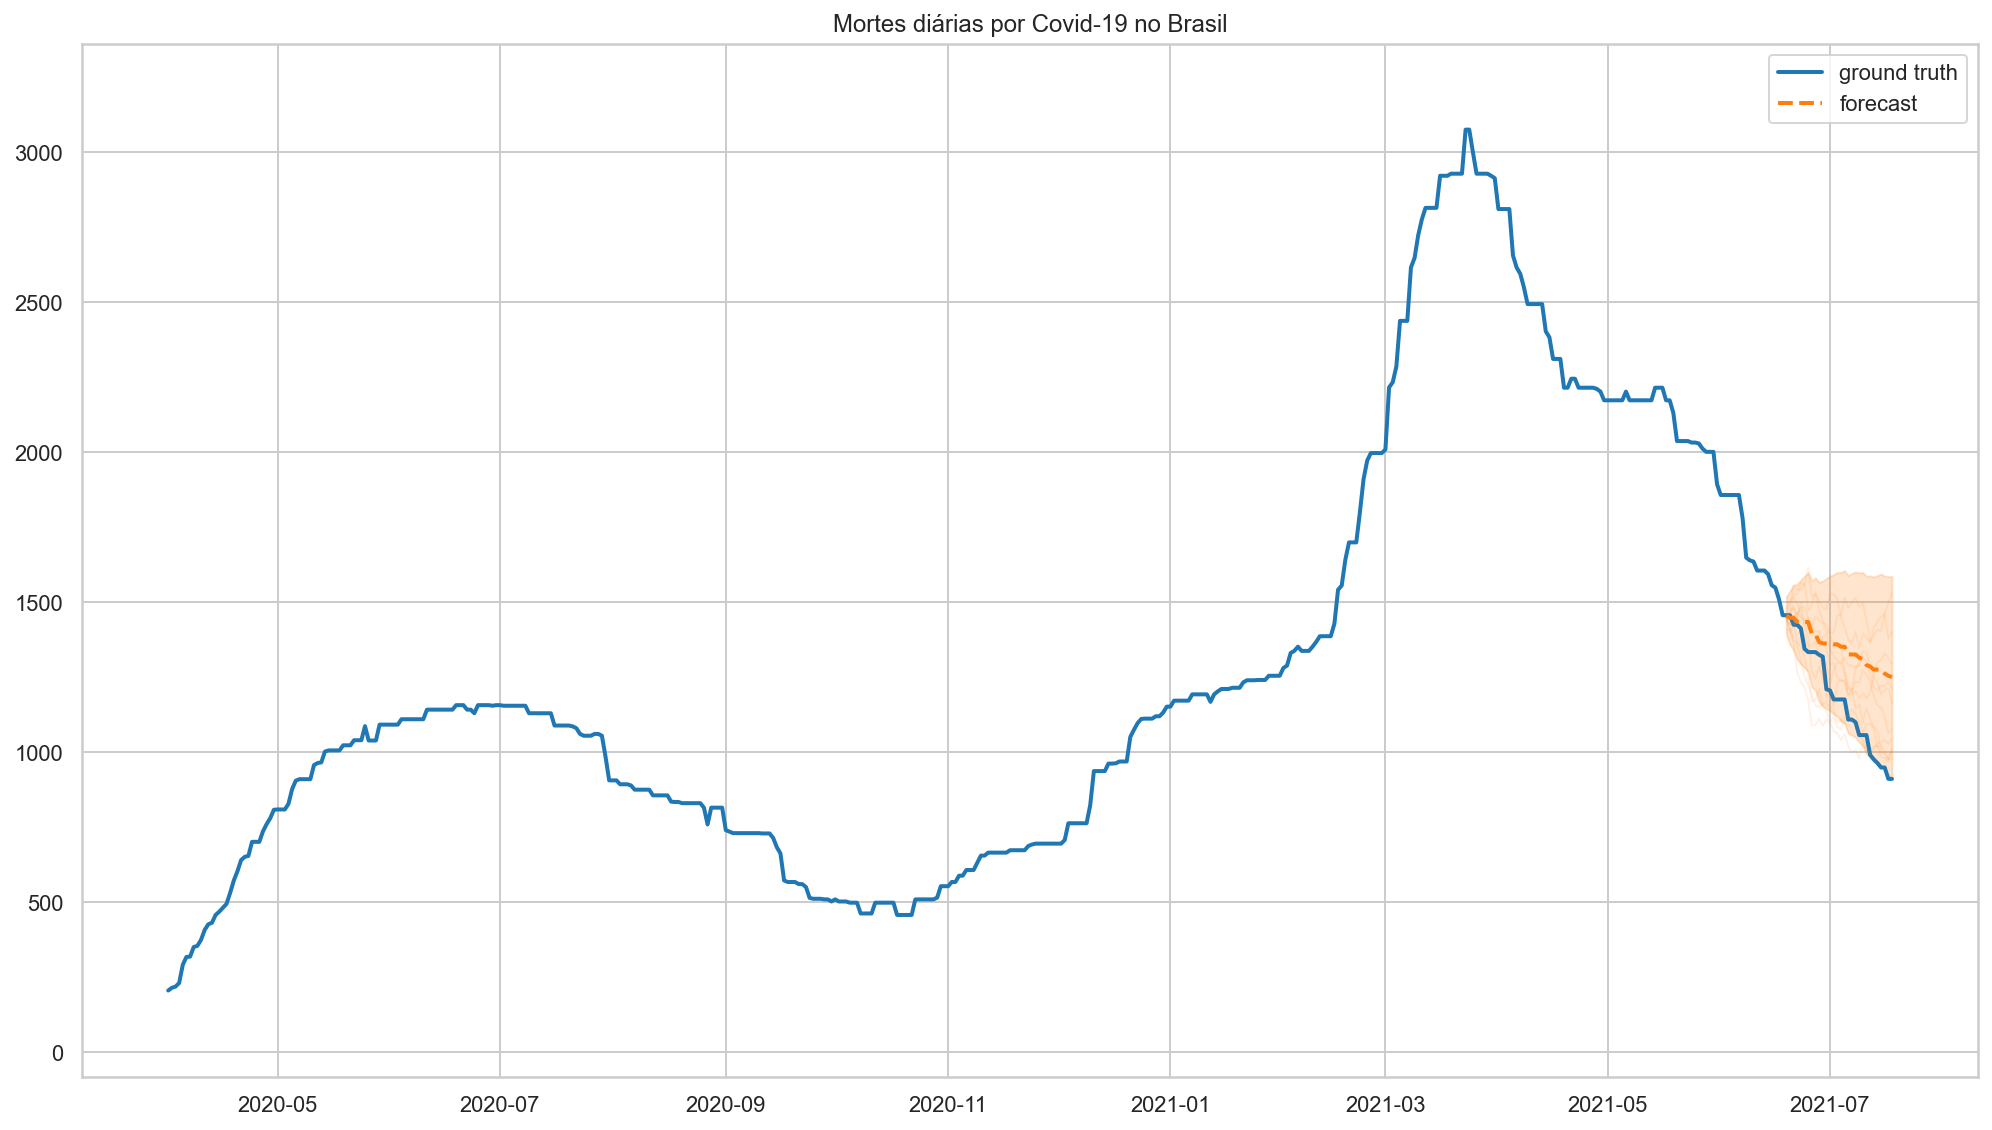

In [21]:
fig, ax = plot_forecast(covid_dates, covid['new_deaths_f'],
                        covid_forecast_mean,
                        covid_forecast_scale,
                        covid_forecast_samples,
                        title="Mortes diárias por Covid-19 no Brasil")#,
                        #x_locator=date_loc, x_formatter=date_fmt)
#ax.set_ylim([0, 10])
fig.tight_layout()

### Decomposição da série

Vamos vizualizar a decomposição das séries observadas e preditas nas suas componentes individuais:

In [22]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    covid_model,
    observed_time_series=covid_training['new_deaths_f'],
    parameter_samples=q_samples_covid_)

forecast_component_dists = sts.decompose_forecast_by_component(
    covid_model,
    forecast_dist=covid_forecast_dist,
    parameter_samples=q_samples_covid_)

In [23]:
covid_component_means_, covid_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    covid_forecast_component_means_,
    covid_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

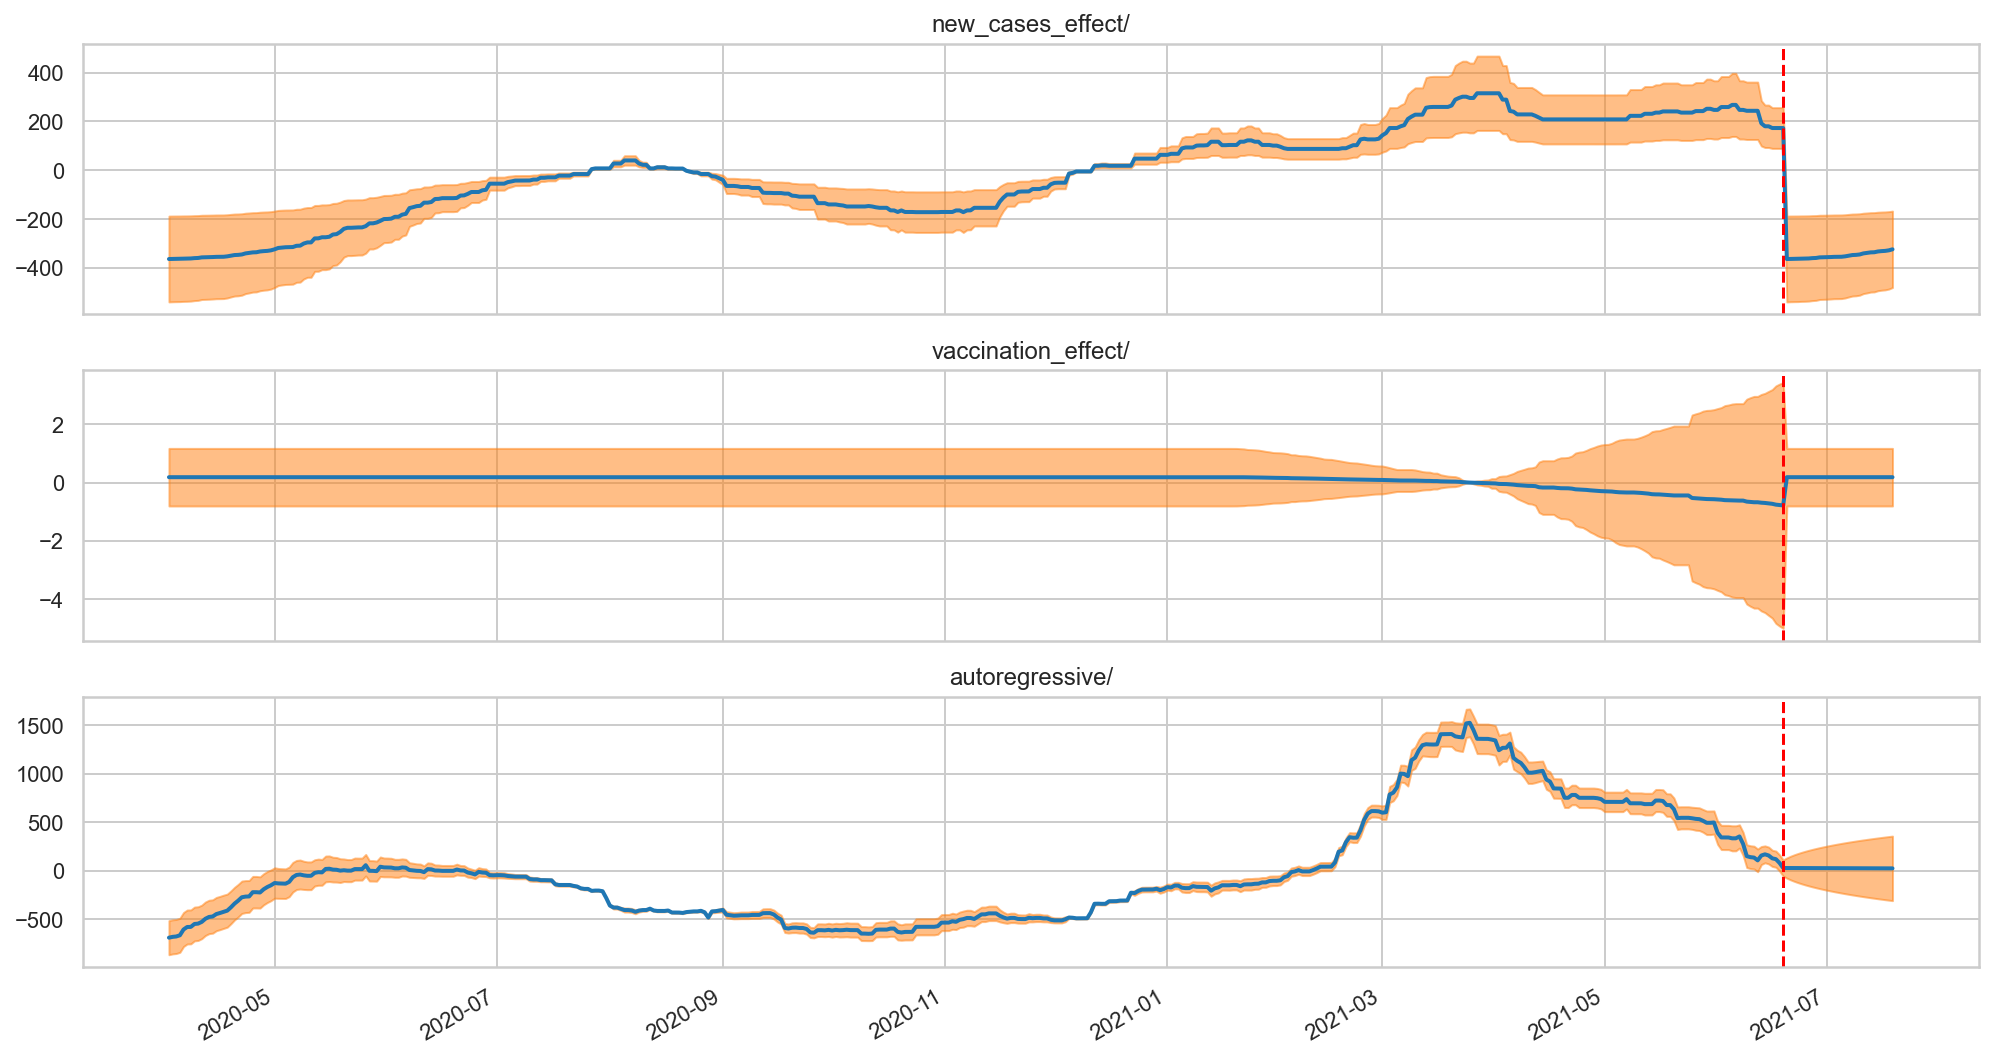

In [24]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in covid_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      covid_component_means_[k],
      covid_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      covid_component_stddevs_[k],
      covid_forecast_component_stddevs_[k]], axis=-1)

fig, axes = plot_components(
  covid.index,
  component_with_forecast_means_,
  component_with_forecast_stddevs_)#,
  #x_locator=date_loc, x_formatter=date_fmt)
for ax in axes.values():
  ax.axvline(covid_dates[-num_forecast_steps], linestyle="--", color='red')

### Anomalias na série

Se quisermos detectar anomalias nas séries observadas, também podemos analisar as distribuições preditivas de um passo: a previsão para cada passo de tempo, dado apenas os passos tempo até o passo anterior. `tfp.sts.one_step_predictive` calcula todas as distribuições preditivas de um passo de uma única vez:

In [25]:
covid_one_step_dist = sts.one_step_predictive(
    covid_model,
    observed_time_series=covid['new_deaths_f'],
    parameter_samples=q_samples_covid_)

covid_one_step_mean, covid_one_step_scale = (
    covid_one_step_dist.mean().numpy(), covid_one_step_dist.stddev().numpy())

Uma forma simples de detectar anomalias na série é marcar todos passos em que as observações são maiores do três desvios padrões -- estes são os passos mais 'discrepantes' de acordo com o modelo.

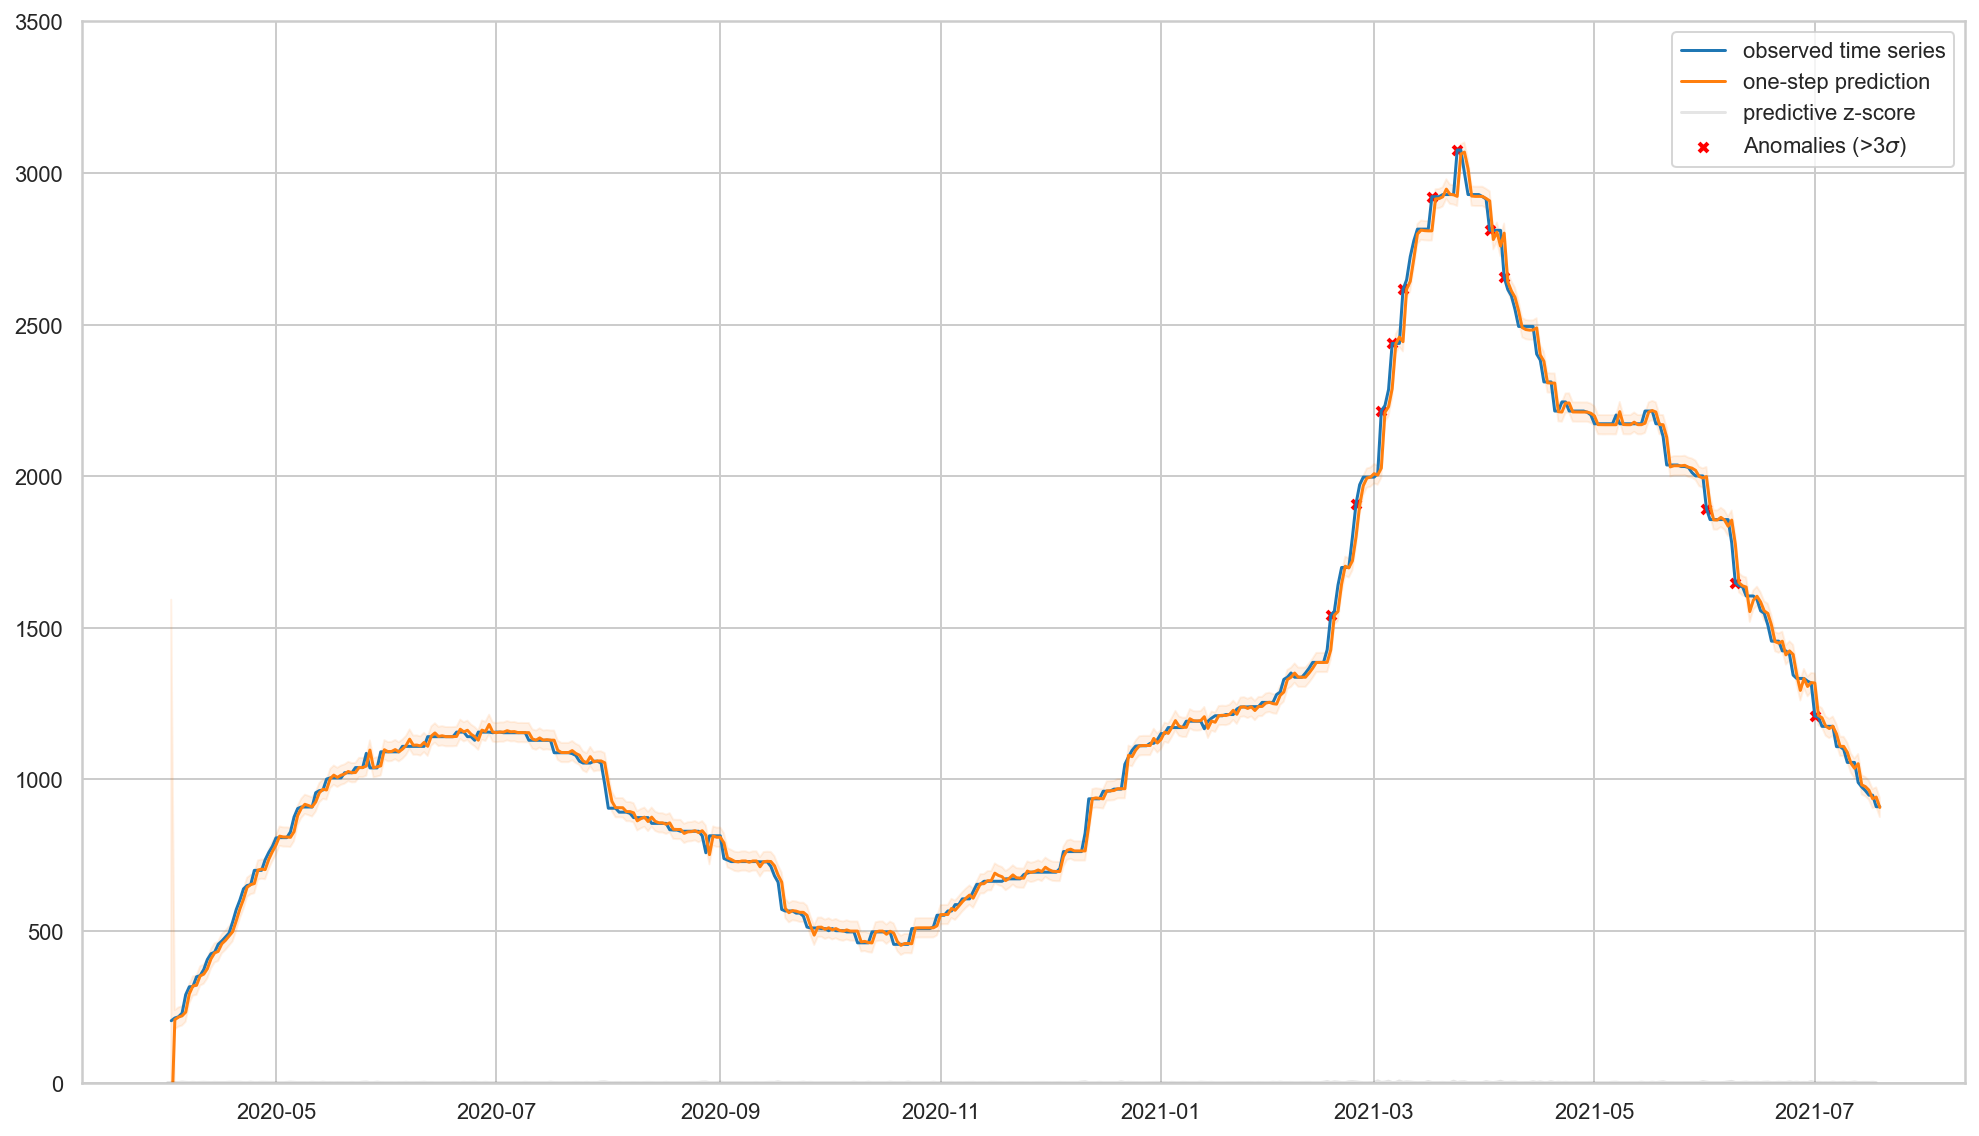

In [26]:
fig, ax = plot_one_step_predictive(
    covid.index, covid['new_deaths_f'],
    covid_one_step_mean, covid_one_step_scale)#,
    #x_locator=date_loc, x_formatter=date_fmt)
ax.set_ylim(0, 3500)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((covid['new_deaths_f'] - covid_one_step_mean) /
                 covid_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(covid.index[anomalies],
           covid['new_deaths_f'].loc[anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(covid_dates, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

## Conclusão

O uso do número de casos diários e da porcentagem de pessoas vacinadas no modelo de espaço de estados permitiu uma previsão razoável do número de óbitos diários dos próximos 30 dias. Embora o resultado seja bom, o modelo ainda apresenta alguns problemas de instabilidade na simulação (rodem outras vezes para verem a variação nos resultados) e não modela adequadamente o comportamento da série. Alguns ajustes no modelo podem ser necessários, como o uso de estados escondidos (como o <a href="https://www.medrxiv.org/content/10.1101/2020.02.29.20029421v1">artigo</a> que mostrei na monitoria).

Como disse na monitoria, o modelo de espaço de estados é bem generalizável, mas vai exigir um estudo mais aprofundado de vocês. Recomendo refazerem os exemplos das aulas e <a href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb">o da demana de energia elétrica da Austrália</a>.

Reparem que os modelos de espaço de estados nada mais são do modelos de evolução de sistemas, em que vocês podem usar variáveis exógenas, tendências locais, níveis locais, sazonalidades e modelos autoregressivos e de médias móveis, junto com o componente aleatório dos resíduos. Para saberem se o modelo está correto, vocês precisam analisar se os resíduos são estacionários, ou seja, não possuam autocorrelação, são homocedásticos (sua variância não varia com o tempo) e possuam distribuição normal. A normalidade dos resíduos não precisa ser satisfeita, mas, quando não for, precisa usar distribuições apropriadas no modelo. Por isso, eu sugiro trabalhar com resíduos que seguem a distribuição normal.